In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, datasets, models
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import pathlib
from pathlib import Path
from torch import nn
import cv2
import numpy as np
import time
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
from torchvision import models
import math

from utils import SteelLoader
from models import UNet, ConvNet_freq, ConvNet_hist, ClassifierNet

###################################################################################################################
################----Define Paths for GB training data, and set up DataLoaders for prediction----###################
###################################################################################################################

###---Note that once you have gathered the training data, you must place it in <data/grains/train/> directory---###
train_path = 'data/grains/train/'

#Define transpose for grayscale classifier network
trans_class = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

#Define transformation for RGB segmentation network
trans_seg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

#Define transformation for Histogram prediction network
trans_hist = transforms.Compose(
    [transforms.ToTensor()])

#Set up the Grain DataLoader
data_seg = SteelLoader(train_path, transform = trans_seg)
data_class = SteelLoader(train_path, transform = trans_class)

#Create batches = 10, shuffle set to False just for demonstration of the framework 
train_seg = DataLoader(data_seg, batch_size=10, shuffle=False)
train_class = DataLoader(data_class, batch_size=10, shuffle=False)

###################################################################################################################
###############################----Define if device for GPU (cuda) or CPU----######################################
###################################################################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###################################################################################################################
########################----Define Model for Classifier CNN, and Load pretrained weights----#######################
###################################################################################################################

class_model = ClassifierNet().to(device)
ClassPath = './Pretrained_weights/pore_vs_grain_weights.pth'

#Enable this line if for CPU use instead of GPU
#class_model.load_state_dict(torch.load(ClassPATH, map_location=torch.device('cpu')))
class_model.load_state_dict(torch.load(ClassPATH))

###################################################################################################################
########################----Define Model for Radius CNN, and Load pretrained weights----###########################
###################################################################################################################


model_rad = ConvNet_hist().to(device)
radPath = './Pretrained_weights/histogram_rad_weights.pth'

#Enable this line if for CPU use instead of GPU
#model_rad = torch.load(radPath, map_location=torch.device('cpu'))
model_rad = torch.load(radPath)

###################################################################################################################
########################----Define Model for Frequency CNN, and Load pretrained weights----########################
###################################################################################################################
        

model_freq = ConvNet_freq().to(device)
freqPath = './Pretrained_weights/histogram_freq_weights.pth'

#Enable this line if for CPU use instead of GPU
#model_freq = torch.load(freqPath, map_location=torch.device('cpu'))
model_freq = torch.load(freqPath)

###################################################################################################################
#######################----Define Model for RGB Segmentation, and Load pretrained weights----######################
###################################################################################################################
  

segment_model = UNet().to(device)
segmentPath = './Pretrained_weights/DENSE_UNet_weights.pth'

#Enable this line if for CPU use instead of GPU
#segment_model = torch.load(segmentPath, map_location=torch.device('cpu'))
segment_model = torch.load(segmentPath)

###################################################################################################################
###################################################################################################################
###################################################################################################################

The image is that of Grains


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


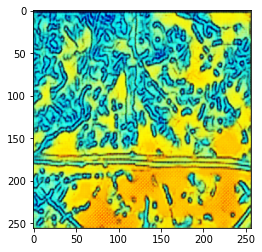

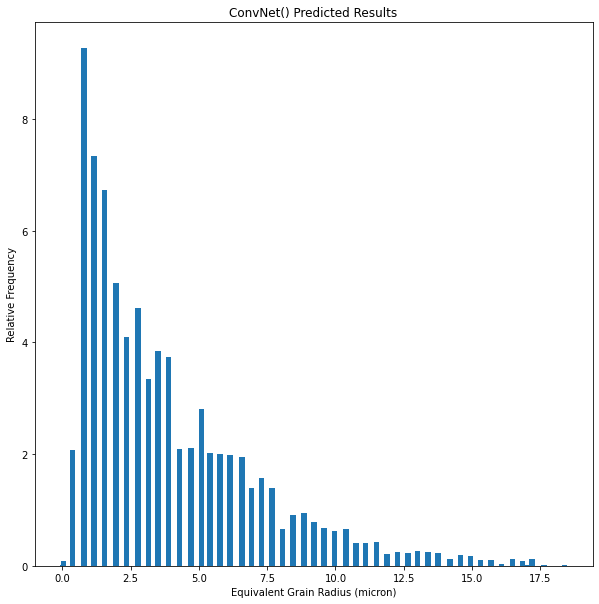

In [2]:
class_sample = next(iter(train_class))
x_class = class_sample['train_image'].to(device)

pore_or_grain = class_model(x_class)
_, predicted_class = torch.max(pore_or_grain, 1)

segment_sample = next(iter(train_seg))
x_seg = segment_sample['train_image'].to(device)

# Set up your own range to characteriza as many GB microstructures as you need
# Only using range(1) for demonstration of the Framework
for i in range(1):

  if predicted_class[i] == 1:
    print("The image is that of Grains")

    # Segmentation Process
    pred = segment_model(x_seg)
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()

    yy = pred[i,:,:,:].transpose((1, 2, 0))
    plt.figure()
    plt.imshow(yy)
    plt.show()

    # Histogram Process
    init_inn = pred[i,:,:,:].transpose((1, 2, 0))
    hist_img = cv2.cvtColor(init_inn, cv2.COLOR_BGR2GRAY)
    inn = trans_hist(hist_img)
    inn = inn.reshape((1,1,256,256))
    inn = inn.type(torch.cuda.FloatTensor)

    #Enable this line if for CPU use instead of GPU
    #inn = inn.type(torch.FloatTensor)

    with torch.no_grad():
      pred_rad = model_rad(inn)
      pred_rad = F.relu(pred_rad)    

    with torch.no_grad():
      pred_freq = model_freq(inn)
      pred_freq = F.relu(pred_freq)

    pred_rad = pred_rad[0,:].cpu().numpy()
    pred_freq = pred_freq[0,:].cpu().numpy() 
    np.round(pred_rad,1) 

    plt.figure(figsize = (10,10))
    plt.bar(pred_rad, pred_freq, width = 0.2)
    plt.xlabel('Equivalent Grain Radius (micron)')
    plt.ylabel('Relative Frequency')
    plt.title('ConvNet() Predicted Results')
    plt.show()

    